# Plots for the Paper

In [1]:
# load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#### import folktables results

In [2]:
STATE = 'ALL'
MODELS = ['LR', 'GBM_opt']

measure_list = ['acc', 'auroc', 'di', 'optim_acc', 'optim_acc_tr', 'auroc_PA', 'BRD']
file_names = {'acc' : 'accuracies', 'auroc' : 'aurocs', 'di' : 'inequalities', 
              'optim_acc' : 'optim_accs', 'optim_acc_tr' : 'optim_acc_train', 
              'auroc_PA' : 'aurocs_PA', 'BRD' : 'base_rates'}

dict = {}
for measure in measure_list:
    dict[measure] = {}

PAs =  ['sex', 'race']


# load data
for measure in ['acc', 'auroc', 'di', 'BRD', 'optim_acc']:
    
    for TASK in ['income', 'employment']:
        dict[measure][TASK] = {}

        for MODEL_CLASS in MODELS:
            dict[measure][TASK][MODEL_CLASS] = {}

            for PROT_ATT in PAs:
                #print(f"Processing: {TASK} | {MODEL_CLASS} | {PROT_ATT}")

                result_folder = f"results/acs-{TASK}-{PROT_ATT}-{MODEL_CLASS}"
                data = []

                if measure == 'BRD':
                    base_rate_df = pd.read_csv(result_folder + f'/base_rates_{STATE}.csv', index_col=0).reset_index(drop=True)
                    dict['BRD'][TASK][MODEL_CLASS][PROT_ATT] = base_rate_df.iloc[0] - base_rate_df.iloc[1] # BR of G1 - BR of G2
                elif measure == 'optim_acc' and MODEL_CLASS == 'GBM_opt':
                    pass
                else:
                    for i in [0,1]:    
                        file_path = f"{result_folder}/{file_names[measure]}_{STATE}_{i}.csv"
                        df = pd.read_csv(file_path, index_col=0).reset_index(drop=True)
                        data.append(df)
                    dict[measure][TASK][MODEL_CLASS][PROT_ATT] = pd.concat(data, axis=1)
                    dict[measure][TASK][MODEL_CLASS][PROT_ATT].columns = ['u', 'a']   # unaware, aware

### Base rate differences per setting

In [3]:
for TASK in ['income', 'employment']:
        for MODEL_CLASS in ['LR']:
            for PROT_ATT in PAs:
                print(f"{TASK} | {MODEL_CLASS} | {PROT_ATT} {dict['BRD'][TASK][MODEL_CLASS][PROT_ATT]}")

income | LR | sex 50000.0    0.151793
dtype: float64
income | LR | race 50000.0    0.144284
dtype: float64
employment | LR | sex 0    0.056128
dtype: float64
employment | LR | race 0    0.059611
dtype: float64


#### import ALMP results

In [5]:
### ALMP
PAs = ['gender', 'citizen']
#group_names ={'gender' : ['male', 'female'], 'citizen' : ['yes', 'no']}
file_names['di'] = 'disp_imps'; file_names['pred_ineq'] = 'inequalities'
# for later: group c
dict['group_c'] = {}

for measure in ['acc', 'auroc', 'di', 'BRD', 'group_c']:
    
    for TASK in ['almp']:
        dict[measure][TASK] = {}

        for MODEL_CLASS in MODELS:
            dict[measure][TASK][MODEL_CLASS] = {}

            for PROT_ATT in PAs:
                #print(f"Processing: {TASK} | {MODEL_CLASS} | {PROT_ATT}")

                result_folder = f"results/{TASK}-{PROT_ATT}-{MODEL_CLASS}"

                if measure in ['di', 'pred_ineq']:
                    dict[measure][TASK][MODEL_CLASS][PROT_ATT] = pd.read_csv(result_folder + f'/{file_names[measure]}.csv', index_col=0).reset_index(drop=True)
                    dict[measure][TASK][MODEL_CLASS][PROT_ATT].columns = ['u', 'a'] # unaware and aware column
                    #dict[measure][TASK][MODEL_CLASS][PROT_ATT] = df['without PA'] - df['with PA'] # compute difference per seed
                    # print(f"Processing: {measure} | {MODEL_CLASS} | {PROT_ATT}")
                    # print(dict[measure][TASK][MODEL_CLASS][PROT_ATT].mean())

                elif measure in ['acc', 'auroc']: # saved in combined file, auc and acc column
                    data = {'acc' : [], 'auroc' : []}
                    for i in [0,1]:    
                        file_path = f"{result_folder}/auroc_acc_{i}.csv"
                        df = pd.read_csv(file_path, index_col=0).reset_index(drop=True)
                        data['acc'].append(df['accuracy'])
                        data['auroc'].append(df['auroc'])
                    dict[measure][TASK][MODEL_CLASS][PROT_ATT] = pd.concat(data[measure], axis=1)
                    dict[measure][TASK][MODEL_CLASS][PROT_ATT].columns = ['u', 'a'] # unaware and aware column
                
                elif measure == 'group_c':
                    dict['group_c'][TASK][MODEL_CLASS][PROT_ATT] = {}
                    for idx, mode in enumerate(['u', 'a']):    
                        file_path = f"{result_folder}/group_c_rates_{idx}.csv"
                        df = pd.read_csv(file_path, index_col=0).reset_index(drop=True)
                        dict['group_c'][TASK][MODEL_CLASS][PROT_ATT][mode] = df # ['u'] gives df for unaware model with cols 'male' and 'female' 


# include by hand
for MODEL_CLASS in MODELS:
    dict['BRD']['almp'][MODEL_CLASS]['gender'] = 0.035767008051107774
    dict['BRD']['almp'][MODEL_CLASS]['citizen'] = 0.1660165321351032

# General results and plots (Section 5)

### Plot: Relative Accuracy loss vs relative DI reduction

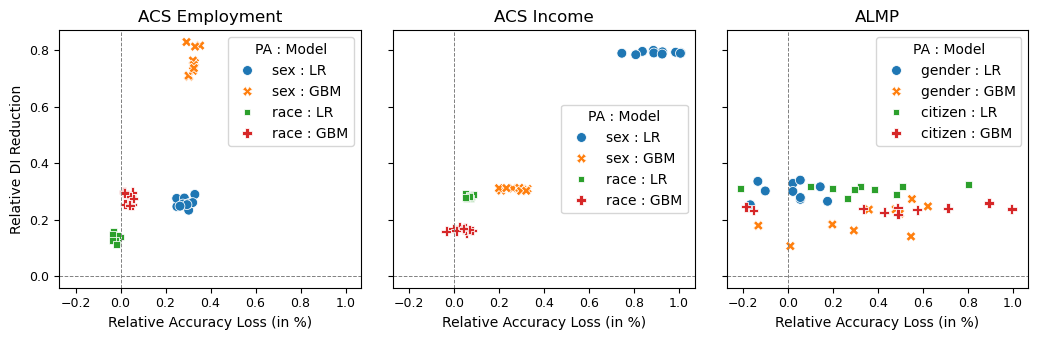

In [6]:

modes = ['unaware', 'aware']
plot_data = []  # Stores relative accuracy loss & DI differences

for TASK in ['income', 'employment', 'almp']:
    PAs = ['gender', 'citizen'] if TASK == 'almp' else ['sex', 'race']
    
    for PROT_ATT in PAs:
        for MODEL_CLASS in MODELS:
            task = 'ALMP' if TASK == 'almp' else 'ACS Income' if TASK == 'income' else 'ACS Employment'
            model = 'GBM' if MODEL_CLASS == 'GBM_opt' else 'LR'
            pa = 'cit' if PROT_ATT == 'citizen' else 'gen' if PROT_ATT == 'gender' else 'race' if PROT_ATT == 'race' else 'sex'
            setting = f"{PROT_ATT} : {model}"
            
            # Compute relative accuracy loss
            df_acc = dict["acc"][TASK][MODEL_CLASS][PROT_ATT]
            relative_acc_loss = (df_acc.iloc[:, 1] - df_acc.iloc[:, 0]) / df_acc.iloc[:, 1]
            # mutiply with 100 for representation in percent
            relative_acc_loss *= 100
            
            # Compute relative DI difference
            df_di = dict["di"][TASK][MODEL_CLASS][PROT_ATT]
            rel_di_diff = (df_di.iloc[:, 1] - np.abs(df_di.iloc[:, 0])) / df_di.iloc[:, 1] # take absolute value since unaware DI sometimes neg for Employment
            
            # Store values for plotting
            for acc, di in zip(relative_acc_loss, rel_di_diff):
                plot_data.append({
                    "Task": task,
                    "PA : Model": setting,
                    "Relative Accuracy Loss": acc,
                    "Relative DI Difference": di
                })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Create three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10.5, 3.5), sharey=True, sharex=True)

# Loop through tasks and plot
for ax, (task, task_data) in zip(axes, df_plot.groupby("Task")):
    sns.scatterplot(
        data=task_data,
        x="Relative Accuracy Loss",
        y="Relative DI Difference",
        hue="PA : Model",
        style="PA : Model",
        ax=ax,
        s=50
    )
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.7)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.7)
    ax.set_title(task)
    ax.set_xlabel("Relative Accuracy Loss (in %)")
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_ylabel("Relative DI Reduction")

plt.tight_layout()
plt.show()


### Alternative plot

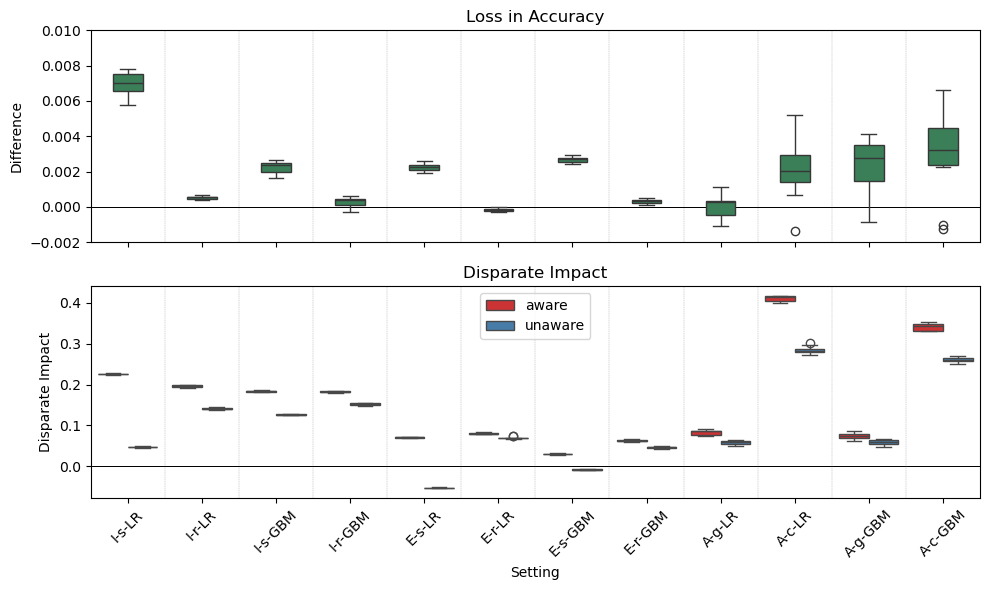

In [7]:
modes = ['unaware', 'aware']
# Prepare data storage
plot_data_acc = []  # Stores accuracy differences
plot_data_di = []   # Stores raw DI values

for TASK in ['income', 'employment', 'almp']:
    PAs = ['gender', 'citizen'] if TASK == 'almp' else ['sex', 'race']
    
    for MODEL_CLASS in MODELS:

        for PROT_ATT in PAs:
            task = 'A' if TASK == 'almp' else 'I' if TASK == 'income' else 'E'
            model = 'GBM' if MODEL_CLASS == 'GBM_opt' else 'LR'
            pa = 'c' if PROT_ATT == 'citizen' else 'g' if PROT_ATT == 'gender' else 'r' if PROT_ATT == 'race' else 's'

            # Get accuracy data
            df_acc = dict["acc"][TASK][MODEL_CLASS][PROT_ATT]
            diff_acc = df_acc.iloc[:, 1] - df_acc.iloc[:, 0]  # Compute accuracy differences
            for d in diff_acc:
                plot_data_acc.append({
                    "Setting": f"{task}-{pa}-{model}",
                    "Difference": d
                })

            # Get DI data (we now store both original values separately)
            df_di = dict["di"][TASK][MODEL_CLASS][PROT_ATT]
            for col_idx, col_name in reversed(list(enumerate(df_di.columns))):
                for value in df_di[col_name]:
                    plot_data_di.append({
                        "Setting": f"{task}-{pa}-{model}",
                        "DI Value": value,
                        "Mode": modes[col_idx]  # Label for the two boxplots per setting
                    })

# Convert to DataFrames for seaborn
df_plot_acc = pd.DataFrame(plot_data_acc)  # For accuracy differences
df_plot_di = pd.DataFrame(plot_data_di)  # For raw DI values

# 🔹 Create Two Subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# 🔹 Add Vertical Lines to Separate Settings
category_labels = df_plot_acc["Setting"].unique()  # Get unique setting labels
category_positions = range(len(category_labels))  # X-axis positions

for pos in category_positions[:-1]:  # Exclude last to avoid extra line
    for ax in axes:  # Apply to both subplots
        ax.axvline(x=pos + 0.5, color="gray", linestyle="--", alpha=0.7, linewidth=.3)
        ax.axhline(y=0, color="black", linestyle="-", alpha=0.4, linewidth=.6) # hor lines

# 🔹 Upper Subplot: Accuracy Differences
sns.boxplot(
    data=df_plot_acc,
    x="Setting",
    y="Difference",
    ax=axes[0],
    color="seagreen",
    width=0.4
)
axes[0].set_title("Loss in Accuracy")
axes[0].set_ylim(-0.002, 0.01)  # Fix y-axis range
axes[0].set_ylabel("Difference")
axes[0].set_xlabel("")  # No x-label for top plot

# 🔹 Lower Subplot: Raw DI Values (Two Boxplots Per Setting)
sns.boxplot(
    data=df_plot_di,
    x="Setting",
    y="DI Value",
    hue="Mode",  # Separate by group (2 per setting)
    ax=axes[1],
    palette="Set1"
)
axes[1].set_title("Disparate Impact")
axes[1].set_ylabel("Disparate Impact")
axes[1].set_xlabel("Setting")
axes[1].legend(loc="upper center")  # Add legend for Group 1 & Group 2

# 🔹 Improve layout
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()

### Table: Absolute accuracies of aware models

In [8]:
for TASK in ['income', 'employment', 'almp']:
    PAs = ['gender'] if TASK == 'almp' else ['sex', 'race']
    
    for MODEL_CLASS in MODELS:
        for PROT_ATT in PAs:
            print(f"Processing: {TASK} | {MODEL_CLASS} | {PROT_ATT}")
            df_a = dict["acc"][TASK][MODEL_CLASS][PROT_ATT]['a']
            print(f'{df_a.mean() * 100:.1f}% pm {df_a.std() * 100:.1f}%')

Processing: income | LR | sex
77.4% pm 0.1%
Processing: income | LR | race
77.1% pm 0.0%
Processing: income | GBM_opt | sex
82.1% pm 0.1%
Processing: income | GBM_opt | race
81.8% pm 0.1%
Processing: employment | LR | sex
77.9% pm 0.0%
Processing: employment | LR | race
78.1% pm 0.1%
Processing: employment | GBM_opt | sex
83.2% pm 0.1%
Processing: employment | GBM_opt | race
83.2% pm 0.0%
Processing: almp | LR | gender
65.0% pm 0.4%
Processing: almp | GBM_opt | gender
66.2% pm 0.3%


### Plot: Disparate Impact by setting

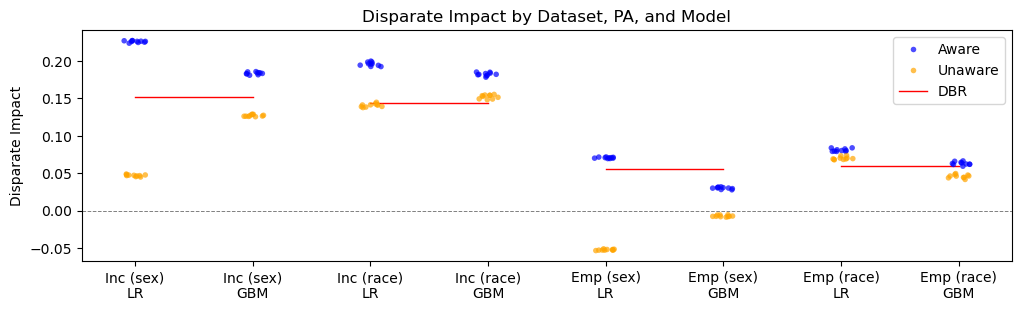

In [9]:
import matplotlib.lines as mlines

# Define datasets and models
TASKS = ["income", "employment"]
PROT_ATTS = ["sex", "race"]
MODELS = ["LR", "GBM_opt"]

# Prepare data for plotting
plot_data = []
brd_values = []

for TASK in TASKS:
    for PROT_ATT in PROT_ATTS:
        for MODEL_CLASS in MODELS:
            # Get DI differences
            df_di = dict["di"][TASK][MODEL_CLASS][PROT_ATT]
            di_aware = df_di.iloc[:, 1].values  # 10 values for aware
            di_unaware = df_di.iloc[:, 0].values  # 10 values for unaware

            # Get BRD
            brd_value = dict["BRD"][TASK][MODEL_CLASS][PROT_ATT]

            # Create x-label for this setting
            dataset_label = "Inc" if TASK == "income" else "Emp"
            model_label = "GBM" if MODEL_CLASS == "GBM_opt" else "LR"
            x_label = f"{dataset_label} ({PROT_ATT})\n{model_label}"

            # Store points for scatter plot
            for aware, unaware in zip(di_aware, di_unaware):
                plot_data.append({"Setting": x_label, "DI": aware, "Type": "Aware"})
                plot_data.append({"Setting": x_label, "DI": unaware, "Type": "Unaware"})

            # Store line data for BRD
            brd_values.append({"Setting": x_label, "BRD": brd_value})

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)
df_brd = pd.DataFrame(brd_values)

# Create the plot
plt.figure(figsize=(12, 3))

# Scatter plot for DI differences
sns.stripplot(data=df_plot, x="Setting", y="DI", hue="Type", 
              jitter=True, size=4, alpha=0.7, palette={"Aware": "blue", "Unaware": "orange"})

# Plot BRD lines
for i in range(0,8,2):
    plt.plot([df_brd.iloc[i,0], df_brd.iloc[i+1,0]], [df_brd.iloc[i,1], df_brd.iloc[i,1]], color="red", linewidth=1)

# Formatting
plt.axhline(0, color="gray", linestyle="--", linewidth=0.7)
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Disparate Impact")
plt.title("Disparate Impact by Dataset, PA, and Model")

# Modify legend
handles, labels = plt.gca().get_legend_handles_labels()  # Get existing legend handles
red_line = mlines.Line2D([], [], color='red', linewidth=1, label='DBR')  # Create custom red line
plt.legend(handles=handles + [red_line], labels=labels + ['DBR'], title=None, loc="upper right")


plt.show()


## Bayes-optimal predictors (of empirical distribution)

In [10]:
for TASK in ['income', 'employment']:
        for MODEL_CLASS in ['LR']:
            for PROT_ATT in ['sex']:
                print(f"{TASK} | {MODEL_CLASS} | {PROT_ATT}", dict['optim_acc'][TASK][MODEL_CLASS][PROT_ATT].iloc[:, 1].mean())
                print(dict['acc'][TASK][MODEL_CLASS][PROT_ATT].iloc[:, 1].mean())
                print(dict['acc'][TASK][MODEL_CLASS][PROT_ATT].iloc[:, 0].mean())

income | LR | sex 0.9989819765695402
0.77405136677681
0.767077801141484
employment | LR | sex 0.8987174416197223
0.7790812117017036
0.7768414856108106


In [11]:
# Disparete impact
for TASK in ['income', 'employment']:
        for MODEL_CLASS in ['LR']:
            for PROT_ATT in ['sex']:
                print(f"{TASK} | {MODEL_CLASS} | {PROT_ATT}")
                print(dict['di'][TASK][MODEL_CLASS][PROT_ATT].iloc[:, 1].mean() - dict['di'][TASK][MODEL_CLASS][PROT_ATT].iloc[:, 0].mean())

income | LR | sex
0.17901285074829063
employment | LR | sex
0.12298503430541637


# Further ALMP results (Section 6)

In [12]:
for TASK in ['almp']:
    for MODEL_CLASS in MODELS:
        for PROT_ATT in  ['gender']:#, 'citizen']:
            print(f"Processing: {TASK} | {MODEL_CLASS} | {PROT_ATT}")
            df_a = dict['group_c'][TASK][MODEL_CLASS][PROT_ATT]['a']
            print('Aware')
            print(f'{df_a['male'].mean() * 100:.1f}% pm {df_a['male'].std() * 100:.1f}%  ',  'male')
            print(f'{df_a['female'].mean()* 100:.1f}% pm {df_a['female'].std() * 100:.1f}% ', 'female')
            print(f'{(df_a['male'] - df_a['female']).mean() * 100:.1f}% pm {(df_a['male'] - df_a['female']).std() * 100:.1f}% ', 'Delta')
            # AUROC
            auc_a = dict['auroc'][TASK][MODEL_CLASS][PROT_ATT]['a']
            print(f'{auc_a.mean():.3f} pm {auc_a.std():.3f}  ',  'AUROC')

            df_u = dict['group_c'][TASK][MODEL_CLASS][PROT_ATT]['u']
            print('Unaware')
            print(f'{df_u['male'].mean() * 100:.1f}% pm {df_u['male'].std() * 100:.1f}% ', 'male')
            print(f'{df_u['female'].mean() * 100:.1f}% pm {df_u['female'].std() * 100:.1f}% ', 'female')
            print(f'{(df_u['male'] - df_u['female']).mean() * 100:.1f}% pm {(df_u['male'] - df_u['female']).std() * 100:.1f}% ', 'Delta')
            # AUROC
            auc_u = dict['auroc'][TASK][MODEL_CLASS][PROT_ATT]['u']
            print(f'{auc_u.mean():.3f} pm {auc_u.std():.3f}  ',  'AUROC')

Processing: almp | LR | gender
Aware
1.6% pm 0.1%   male
2.2% pm 0.2%  female
-0.7% pm 0.3%  Delta
0.680 pm 0.002   AUROC
Unaware
1.7% pm 0.1%  male
2.0% pm 0.2%  female
-0.2% pm 0.2%  Delta
0.680 pm 0.002   AUROC
Processing: almp | GBM_opt | gender
Aware
3.9% pm 0.3%   male
8.3% pm 0.4%  female
-4.4% pm 0.4%  Delta
0.700 pm 0.003   AUROC
Unaware
4.5% pm 0.1%  male
6.1% pm 0.2%  female
-1.6% pm 0.2%  Delta
0.697 pm 0.003   AUROC
